# Imports

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector
import re 

# Functions

## MySql table name check

In [2]:
def sanitize_table_name(name):
    sanitized_name = re.sub('[^a-zA-Z0-9_]', '', name)
    return sanitized_name

## DataFrame pre-processing

In [3]:
def condition_binarize(condition):
    if "No accidents" in condition:
        return 0
    else:
        return 1

def price_int(price):
    return int(str.join("",price.strip('$').split(',')))

def mile_int(mile):
    return int(str.join("",mile.split(" ")[0].split(",")))

# Connecting to MySql 

In [ ]:
cnx = mysql.connector.connect(user=input("database user: "), password=input("database password: "),
                              host=input("database host: "),
                              database=input("database name: "))

# Scraping and Transfering 

In [5]:
car_name = input("Enter a car name(for example bmw x5): ")
sanitized_car_name = sanitize_table_name(car_name)


driver = webdriver.Chrome()
driver.get('https://www.truecar.com/')

search_bar = driver.find_element(By.ID, 'homePageSearchBarLgOmnisearchSearchField')
search_bar.clear()
search_bar.send_keys(car_name[:5])
time.sleep(1)
search_bar.send_keys(car_name[5:])
time.sleep(1)
search_bar.send_keys(Keys.ENTER)

time.sleep(5)
driver.implicitly_wait(3)



car = {"miles":[],"price":[],"condition":[]}
for page in range(5):
    prices = driver.find_elements(By.CSS_SELECTOR, '[data-test="vehicleCardPricingBlockPrice"]')
    miles = driver.find_elements(By.CSS_SELECTOR,'[data-test="vehicleMileage"]')
    car_conditions = driver.find_elements(By.CSS_SELECTOR,'[data-test="vehicleCardCondition"]')

    for price in prices:
        p = price.text
        try:
            car["price"].append(p.split('\n')[-1])
        except:
            car['price'].append(p)


    
    for mile in miles:
        car["miles"].append(mile.text)

    for condition in car_conditions:
        car["condition"].append(condition.text)


    try:
        next_page = driver.find_element(By.CSS_SELECTOR,'[data-test="Pagination-directional-next"]')
        next_page.click()
        time.sleep(5)
        driver.implicitly_wait(3)
    except:
           break



car_df = pd.DataFrame(car) 



car_df['condition'] = car_df['condition'].apply(condition_binarize)
car_df['price'] = car_df['price'].apply(price_int)
car_df['miles'] = car_df['miles'].apply(mile_int)

cursor = cnx.cursor()

create_table = f"""
    CREATE TABLE IF NOT EXISTS {sanitized_car_name} (
        miles INT,
        price INT,
        `condition` INT
    )
"""
cursor.execute(create_table)

for i, row in car_df.iterrows():
    sql = f"INSERT INTO {sanitized_car_name} (miles, price, `condition`) VALUES (%s, %s, %s)"
    values = (int(row['miles']), int(row['price']), int(row['condition']))
    cursor.execute(sql, values)
    
cnx.commit()
cursor.close()
cnx.close()
driver.quit()

Enter a car name(for example bmw x5):  bmw x5


# collected data

In [6]:
car_df.head(10)

,miles,price,condition
0,62631,15300,0
1,43065,40995,0
2,48507,43795,0
3,111345,7995,0
4,38772,42998,0
5,139620,9999,1
6,44760,45487,0
7,110633,15900,0
8,36342,46549,0
9,43538,39083,0


# Connecting to DB and read data for further processing

In [ ]:
mydb = mysql.connector.connect(
  host=input("localhost db: "),
  user=input("user db: "),
  password=input('password db: '),
  database=input('name of db: ')
)

cursor = mydb.cursor()
cursor.execute("SHOW TABLES")
tables = cursor.fetchall()

## showing available tables in DB and selecting the desired table

In [9]:
print("Available tables:")
for table in tables:
  print(table[0])

table_name = input("Enter the name of the table to retrieve: ")

Available tables:
bmwx5
toyota


Enter the name of the table to retrieve:  bmwx5


## Extracting Data from DB into a DataFrame

In [10]:
cursor.execute(f"SELECT * FROM {table_name}")
results = cursor.fetchall()

df = pd.DataFrame(results, columns=[i[0] for i in cursor.description])

cursor.close()
mydb.close()

# Training a Regression Model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[['miles', 'condition']], df['price'], test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print('Root Mean Squared Error():  $%.2f'%(rmse))

Root Mean Squared Error():  $5860.13


# Visualisation of Results

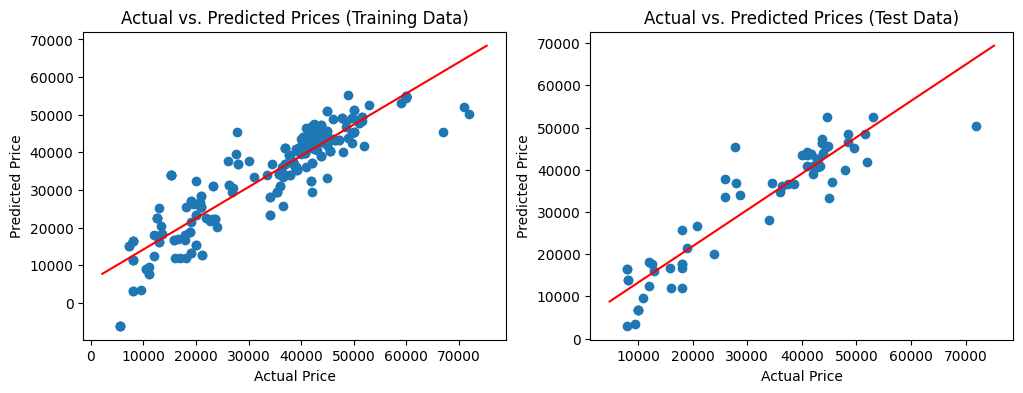

In [12]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].scatter(y_train, y_train_pred)
axs[0].set_xlabel('Actual Price')
axs[0].set_ylabel('Predicted Price')
axs[0].set_title('Actual vs. Predicted Prices (Training Data)')
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
slope, intercept, = np.polyfit(y_train, y_train_pred, 1)
x = np.linspace(xmin, xmax, 100)
y = slope * x + intercept
axs[0].plot(x, y, color='r')

axs[1].scatter(y_test, y_test_pred)
axs[1].set_xlabel('Actual Price')
axs[1].set_ylabel('Predicted Price')
axs[1].set_title('Actual vs. Predicted Prices (Test Data)')
xmin, xmax = axs[1].get_xlim()
ymin, ymax = axs[1].get_ylim()
slope, intercept, = np.polyfit(y_test, y_test_pred, 1)
x = np.linspace(xmin, xmax, 100)
y = slope * x + intercept
axs[1].plot(x, y, color='r')

plt.show()